In [231]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
sns.set(style='dark', palette='muted', color_codes=True)
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px 

In [232]:
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,OneHotEncoder,StandardScaler,MinMaxScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score,silhouette_score, confusion_matrix 
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans 
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [233]:
data = pd.read_csv(r'c:\Github\Sol\the_data\data-lab-5-hcv.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


In [234]:
mis_val = data.isna().sum() * 100/len(data)

mis_val.sort_values(ascending=False)

ALP           2.926829
CHOL          1.626016
ALB           0.162602
ALT           0.162602
PROT          0.162602
Unnamed: 0    0.000000
Category      0.000000
Age           0.000000
Sex           0.000000
AST           0.000000
BIL           0.000000
CHE           0.000000
CREA          0.000000
GGT           0.000000
dtype: float64

In [235]:
data.duplicated().sum()

0

In [236]:
mean_imp = SimpleImputer(missing_values=np.NaN, strategy='mean')

data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']] = mean_imp.fit_transform(data[['ALP', 'CHOL', 'ALB', 'ALT', 'PROT']])

data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [237]:
mis_val = data.isna().sum() * 100/len(data)

mis_val.sort_values(ascending=False)

Category    0.0
Age         0.0
Sex         0.0
ALB         0.0
ALP         0.0
ALT         0.0
AST         0.0
BIL         0.0
CHE         0.0
CHOL        0.0
CREA        0.0
GGT         0.0
PROT        0.0
dtype: float64

<AxesSubplot:title={'center':'Correlation Matrix'}>

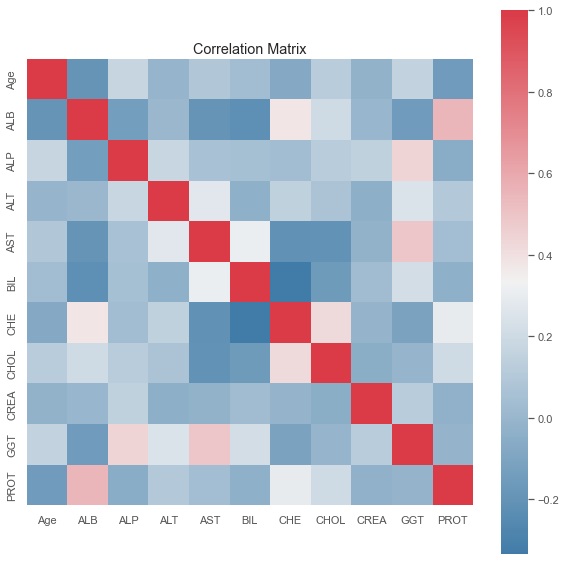

In [238]:
data_corr = data.corr()

f,ax = plt.subplots(figsize=(10,10))

ax.set_title('Correlation Matrix')

sns.heatmap(data_corr, mask=np.zeros_like(data_corr, dtype=np.bool_), cmap=sns.diverging_palette(240,10, as_cmap=True), square=True, ax=ax)

In [239]:
le = LabelEncoder()

y = data.Category 

y_true = le.fit_transform(y)

data = pd.get_dummies(data, dtype=float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              615 non-null    int64  
 1   ALB                              615 non-null    float64
 2   ALP                              615 non-null    float64
 3   ALT                              615 non-null    float64
 4   AST                              615 non-null    float64
 5   BIL                              615 non-null    float64
 6   CHE                              615 non-null    float64
 7   CHOL                             615 non-null    float64
 8   CREA                             615 non-null    float64
 9   GGT                              615 non-null    float64
 10  PROT                             615 non-null    float64
 11  Category_0=Blood Donor           615 non-null    float64
 12  Category_0s=suspect Bl

In [240]:
le.classes_ 

n_clusters = len(le.classes_)

In [241]:
preprocessing = Pipeline( 
    [ 
        ('scaler', MinMaxScaler()),
        ('pca', PCA(n_components=2, random_state=42))
    ]
)

In [242]:
clusterer = Pipeline( 
    [ 
        (
            'kmeans',
            KMeans( 
                n_clusters=n_clusters,
                init='k-means++',
                n_init=50,
                max_iter=500,
                random_state=42,
            )
        )
    ]
)

In [243]:
pipe = Pipeline( 
    [ 
        ('preprocessing', preprocessing),
        ('clusterer',clusterer)
    ]
)

In [244]:
pipe.fit(data)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [245]:
preprocessed_data = pipe['preprocessing'].transform(data)
predicted_labels = pipe['clusterer']['kmeans'].labels_

In [246]:
# data['predicted_labels']=predicted_labels 
# data.tail(2)

In [247]:
mod_scr = silhouette_score(preprocessed_data,predicted_labels).round(3)
mod_scr

0.946

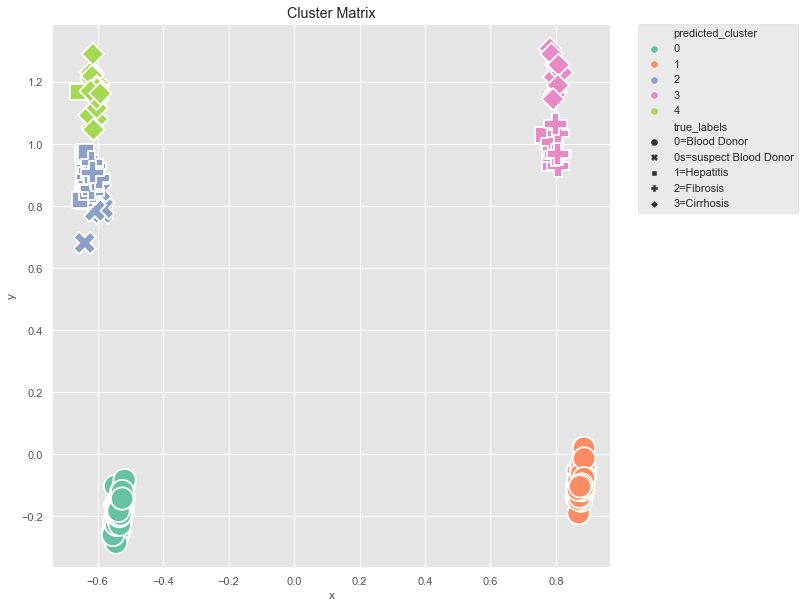

In [248]:
pcdaf = pd.DataFrame( 
    preprocessed_data, columns=['x', 'y']
)

pcdaf['predicted_cluster'] = predicted_labels 
pcdaf['true_labels'] = le.inverse_transform(y_true)

f,ax = plt.subplots(figsize=(10,10))

ax.set_title('Cluster Matrix')

scatt = sns.scatterplot( 
    data=pcdaf,
    s=500,
    x= 'x',
    y = 'y',
    hue='predicted_cluster',
    style='true_labels',
    palette='Set2'
)



plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0.0)